<a href="https://colab.research.google.com/github/dataplusplus-ai/EVA7/blob/main/ResNets%20and%20Higher%20receptive%20Fields/Advanced_Training_Concepts_CIFAR10_Image_Classification_custom_Resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import libraries

In [1]:
!pip install git+https://github.com/albumentations-team/albumentations.git
!pip install torchsummary
!pip install torch_lr_finder
!pip install hidden layer

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-jc7agzz2
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-jc7agzz2
     |████████████████████████████████| 47.6 MB 3.5 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=103647 sha256=39cda29c22064917cf7e8107e601b9fb971b20c8bf5cb4e1efa7838adc5709b3
  Stored in directory: /tmp/pip-ephem-wheel-cache-n8jzcjgy/wheels/09/5b/e0/38cb85186b3cb979092395de69893163f9a223a72066123599
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12
ERROR: Could not find a version that satisfies the requirement hidden (from versions: none)
ERROR: No matching distribution found for hidden


In [2]:
!git clone https://github.com/dataplusplus-ai/torch_cv_wrapper.git

Cloning into 'torch_cv_wrapper'...
remote: Enumerating objects: 135, done.
remote: Counting objects: 100% (135/135), done.
remote: Compressing objects: 100% (127/127), done.
remote: Total 135 (delta 62), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (135/135), 44.02 KiB | 8.80 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [5]:
from __future__ import print_function
import torchvision
import torch
from pprint import pprint
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

## Import Custom Libraries
from torch_cv_wrapper.utils import plot_metrics,train,test,helper
from torch_cv_wrapper.utils.gradcam import generate_gradcam, plot_gradcam
from torch_cv_wrapper.model import custom_ResNet
#from torch_cv_wrapper import config



In [7]:
from torch_cv_wrapper.main import TriggerEngine

## Load config file

In [8]:

config= helper.process_config('/content/config.yaml') 
use_cuda = torch.cuda.is_available()
helper.set_seed(config['model_params']['seed'],use_cuda)
device = torch.device("cuda" if use_cuda else "cpu")
pprint(config)

 loading Configuration of your experiment ..
{'criterion': 'CrossEntropyLoss',
 'data_augmentation': {'type': 'CIFAR10AlbumentationS9'},
 'data_loader': {'args': {'batch_size': 512,
                          'num_workers': 2,
                          'pin_memory': True},
                 'classes': ['plane',
                             'car',
                             'bird',
                             'cat',
                             'deer',
                             'dog',
                             'frog',
                             'horse',
                             'ship',
                             'truck'],
                 'type': 'Cifar10DataLoader'},
 'lr_finder': {'lr_epochs': 25, 'max_epoch': 5},
 'lr_scheduler': 'OneCycleLR',
 'model': 'custom_Resnet',
 'model_params': {'dropout': 0.05,
                  'experiment_name': 'cifar10_with_customresnet',
                  'model_dir': './model/',
                  'seed': 1},
 'optimizer': {'args': {'lr'

## Create Training Instance

In [10]:
exp_metrics={}
experiment_name=config['model_params']['experiment_name']
trigger_training=TriggerEngine(config)

## Download data and view sample images

In [11]:
classes= config['data_loader']['classes']

#Get dataloaders
train_loader,test_loader = trigger_training.dataloader()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


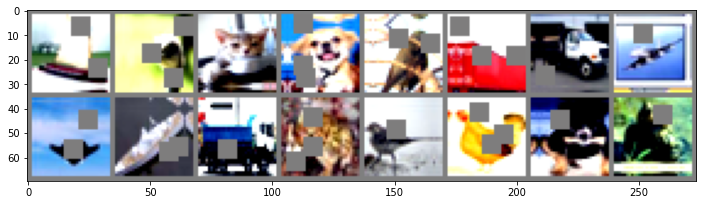

In [12]:
# get some random training images
images, labels = iter(train_loader).next()

# # show images
helper.imshow(torchvision.utils.make_grid(images[:16]))

## Model Summary

In [13]:
model = custom_ResNet.CustomResNet()
model.to(device)
trigger_training.model_summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
       BasicBlock-14          [-1, 128,

# **Visualize Architecture**

# **Find best LR**

In [14]:
from torch_lr_finder import LRFinder

In [15]:
import time
start = time.time()
start_lr = 1e-3
end_lr = 0.5 # 1.0 the graph is dierging
lr_max = trigger_training.find_lr(model,train_loader,test_loader,start_lr,end_lr)
end= time.time()


  0%|          | 0/500 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()


In [16]:
lr_max

0.268

## Trigger training

In [20]:
# trigger_training.
(exp_metrics[experiment_name]) = trigger_training.run_experiment(model,train_loader,test_loader,start_lr,lr_max)
#trigger_training.save_experiment(model,experiment_name,"/content/saved_models")

Epoch 1:


Loss=1.9105336666107178 Batch_id=97 LR=0.05598 Accuracy=29.99: 100%|██████████| 98/98 [00:54<00:00,  1.78it/s]



Test set: Average loss: 0.0037, Accuracy: 3254/10000 (32.54%)

Epoch 2:


Loss=1.3634164333343506 Batch_id=97 LR=0.11480 Accuracy=46.06: 100%|██████████| 98/98 [00:55<00:00,  1.78it/s]



Test set: Average loss: 0.0030, Accuracy: 4558/10000 (45.58%)

Epoch 3:


Loss=0.9226760864257812 Batch_id=97 LR=0.18741 Accuracy=61.29: 100%|██████████| 98/98 [00:55<00:00,  1.78it/s]



Test set: Average loss: 0.0021, Accuracy: 6349/10000 (63.49%)

Epoch 4:


Loss=0.7135415077209473 Batch_id=97 LR=0.24596 Accuracy=68.25: 100%|██████████| 98/98 [00:54<00:00,  1.78it/s]



Test set: Average loss: 0.0025, Accuracy: 5576/10000 (55.76%)

Epoch 5:


Loss=0.8716841340065002 Batch_id=97 LR=0.26800 Accuracy=69.76: 100%|██████████| 98/98 [00:54<00:00,  1.79it/s]



Test set: Average loss: 0.0030, Accuracy: 5298/10000 (52.98%)

Epoch 6:


Loss=0.807977557182312 Batch_id=97 LR=0.26614 Accuracy=70.89: 100%|██████████| 98/98 [00:54<00:00,  1.79it/s]



Test set: Average loss: 0.0020, Accuracy: 6366/10000 (63.66%)

Epoch 7:


Loss=0.7919117212295532 Batch_id=97 LR=0.26067 Accuracy=72.32: 100%|██████████| 98/98 [00:54<00:00,  1.79it/s]



Test set: Average loss: 0.0021, Accuracy: 6604/10000 (66.04%)

Epoch 8:


Loss=0.8361509442329407 Batch_id=97 LR=0.25174 Accuracy=72.55: 100%|██████████| 98/98 [00:54<00:00,  1.80it/s]



Test set: Average loss: 0.0020, Accuracy: 6475/10000 (64.75%)

Epoch 9:


Loss=0.7878806591033936 Batch_id=97 LR=0.23961 Accuracy=72.88: 100%|██████████| 98/98 [00:54<00:00,  1.80it/s]



Test set: Average loss: 0.0023, Accuracy: 6277/10000 (62.77%)

Epoch 10:


Loss=0.6994244456291199 Batch_id=97 LR=0.22459 Accuracy=73.06: 100%|██████████| 98/98 [00:54<00:00,  1.80it/s]



Test set: Average loss: 0.0026, Accuracy: 6002/10000 (60.02%)

Epoch 11:


Loss=0.7122523188591003 Batch_id=97 LR=0.20710 Accuracy=74.03: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]



Test set: Average loss: 0.0037, Accuracy: 5139/10000 (51.39%)

Epoch 12:


Loss=0.7527581453323364 Batch_id=97 LR=0.18762 Accuracy=74.57: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]



Test set: Average loss: 0.0019, Accuracy: 6739/10000 (67.39%)

Epoch 13:


Loss=0.6730099320411682 Batch_id=97 LR=0.16668 Accuracy=75.12: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]



Test set: Average loss: 0.0019, Accuracy: 6863/10000 (68.63%)

Epoch 14:


Loss=0.7236506342887878 Batch_id=97 LR=0.14484 Accuracy=75.67: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]



Test set: Average loss: 0.0018, Accuracy: 6992/10000 (69.92%)

Epoch 15:


Loss=0.7216722369194031 Batch_id=97 LR=0.12271 Accuracy=76.78: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]



Test set: Average loss: 0.0015, Accuracy: 7446/10000 (74.46%)

Epoch 16:


Loss=0.5682244300842285 Batch_id=97 LR=0.10089 Accuracy=77.53: 100%|██████████| 98/98 [00:54<00:00,  1.81it/s]



Test set: Average loss: 0.0015, Accuracy: 7528/10000 (75.28%)

Epoch 17:


Loss=0.6836804151535034 Batch_id=97 LR=0.07997 Accuracy=78.88: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]



Test set: Average loss: 0.0021, Accuracy: 6481/10000 (64.81%)

Epoch 18:


Loss=0.5987664461135864 Batch_id=97 LR=0.06052 Accuracy=79.97: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]



Test set: Average loss: 0.0012, Accuracy: 7855/10000 (78.55%)

Epoch 19:


Loss=0.48867717385292053 Batch_id=97 LR=0.04308 Accuracy=81.55: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]



Test set: Average loss: 0.0017, Accuracy: 7155/10000 (71.55%)

Epoch 20:


Loss=0.4445016086101532 Batch_id=97 LR=0.02812 Accuracy=83.54: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]



Test set: Average loss: 0.0013, Accuracy: 7837/10000 (78.37%)

Epoch 21:


Loss=0.459189236164093 Batch_id=97 LR=0.01605 Accuracy=86.03: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]



Test set: Average loss: 0.0009, Accuracy: 8494/10000 (84.94%)

Epoch 22:


Loss=0.28029733896255493 Batch_id=97 LR=0.00719 Accuracy=88.98: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]



Test set: Average loss: 0.0007, Accuracy: 8751/10000 (87.51%)

Epoch 23:


Loss=0.20826689898967743 Batch_id=97 LR=0.00179 Accuracy=91.79: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]



Test set: Average loss: 0.0006, Accuracy: 9021/10000 (90.21%)

Epoch 24:


Loss=0.2200206071138382 Batch_id=97 LR=0.00000 Accuracy=93.48: 100%|██████████| 98/98 [00:53<00:00,  1.82it/s]



Test set: Average loss: 0.0006, Accuracy: 9024/10000 (90.24%)



## Missclassification

Total wrong predictions are 976
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


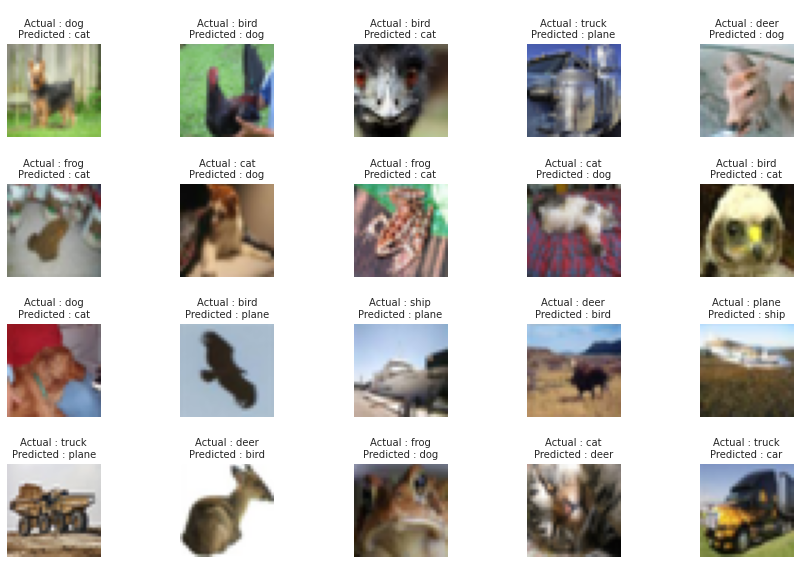

In [22]:
misclassified_images = trigger_training.wrong_predictions(model,test_loader,num_img=20)

## Plots for Validation Loss and Accuracy

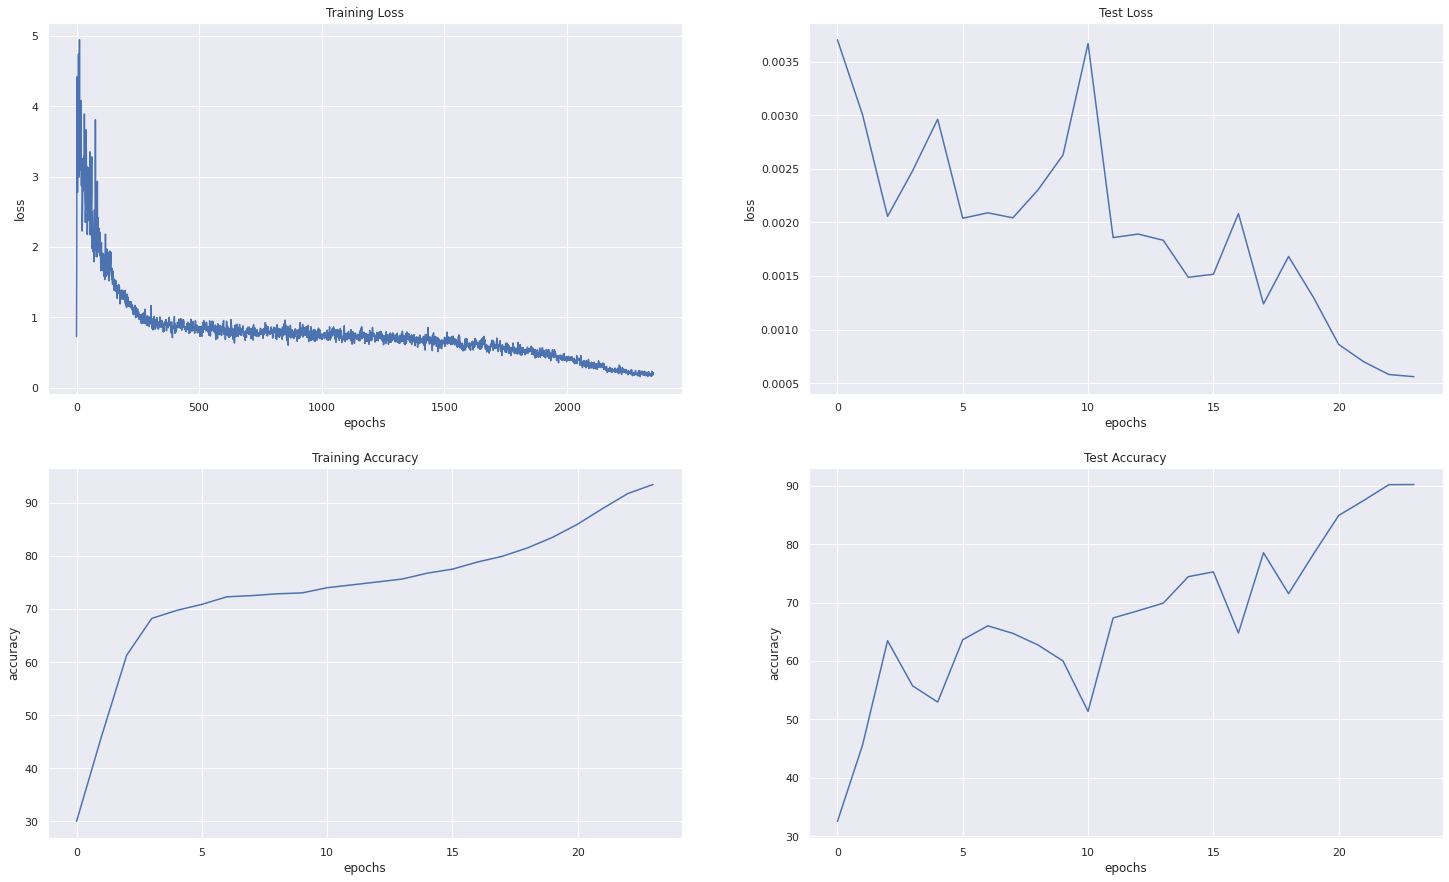

In [21]:
plot_metrics.plot_metrics(exp_metrics[experiment_name])

## Accuracy for each class

In [23]:
helper.class_level_accuracy(model, test_loader, device, classes)

Accuracy of plane : 91 %
Accuracy of   car : 96 %
Accuracy of  bird : 86 %
Accuracy of   cat : 78 %
Accuracy of  deer : 89 %
Accuracy of   dog : 86 %
Accuracy of  frog : 93 %
Accuracy of horse : 93 %
Accuracy of  ship : 93 %
Accuracy of truck : 93 %


## Plot Confusion Matrix

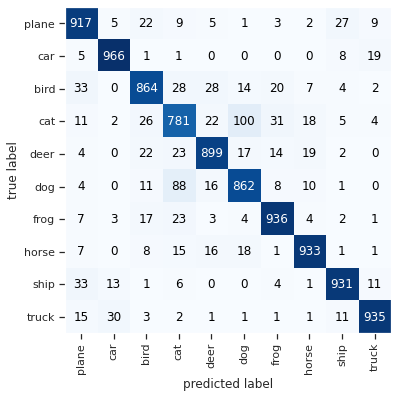

In [24]:
mat = helper.compute_confusion_matrix(model,test_loader,device)
plot_metrics.plot_confusion_matrix(mat, class_names=classes)


## Generate & Plot GradCam Images

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


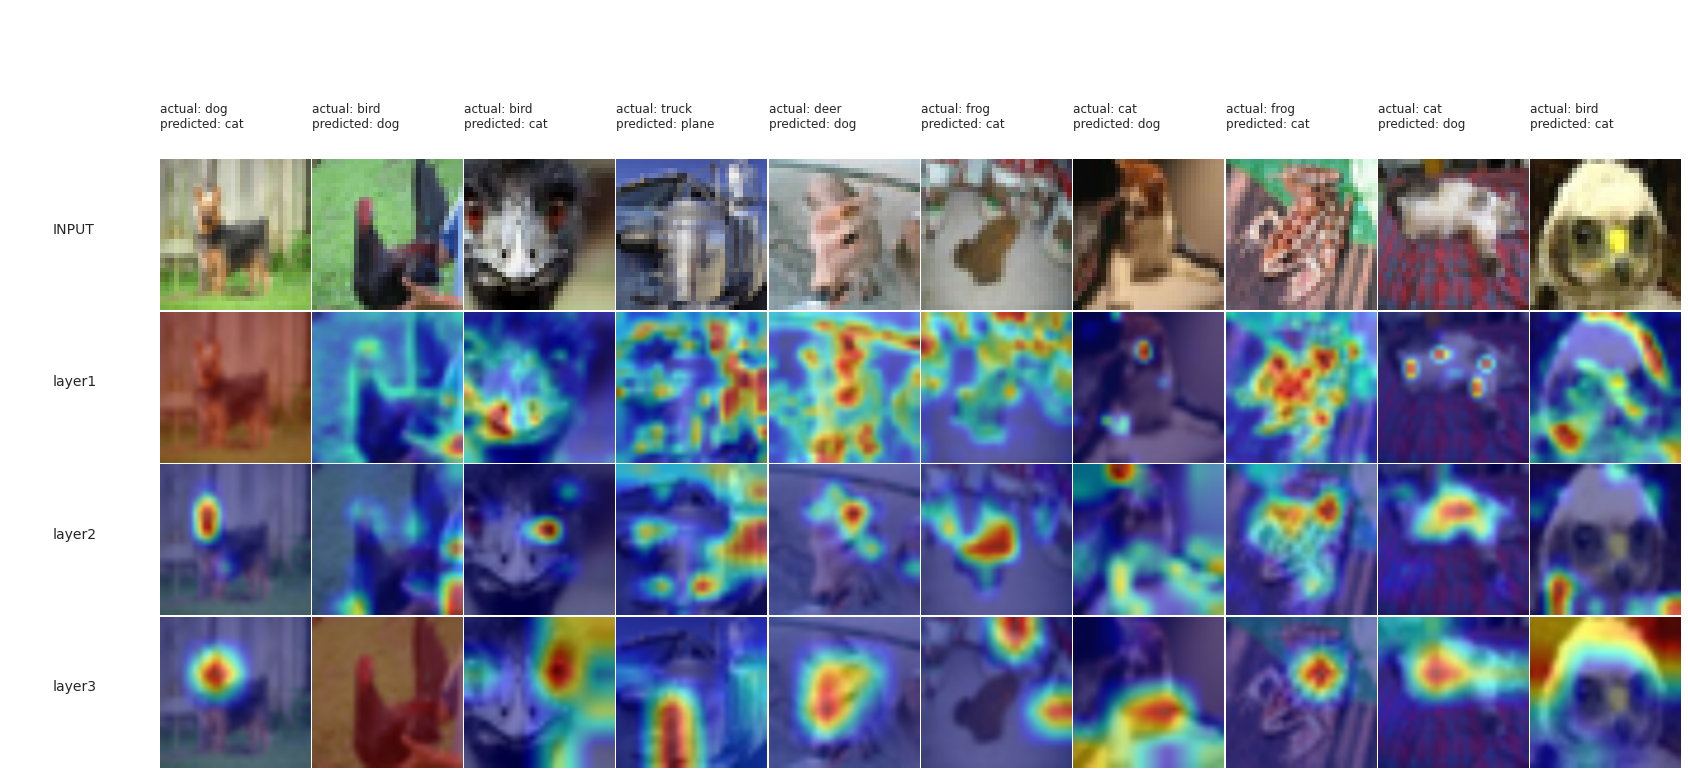

In [27]:
target_layers = ["layer1","layer2","layer3"]
gradcam_output, probs, predicted_classes = generate_gradcam(misclassified_images[:10], model, target_layers,device)
plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[:10])

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


torch.Size([10, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3


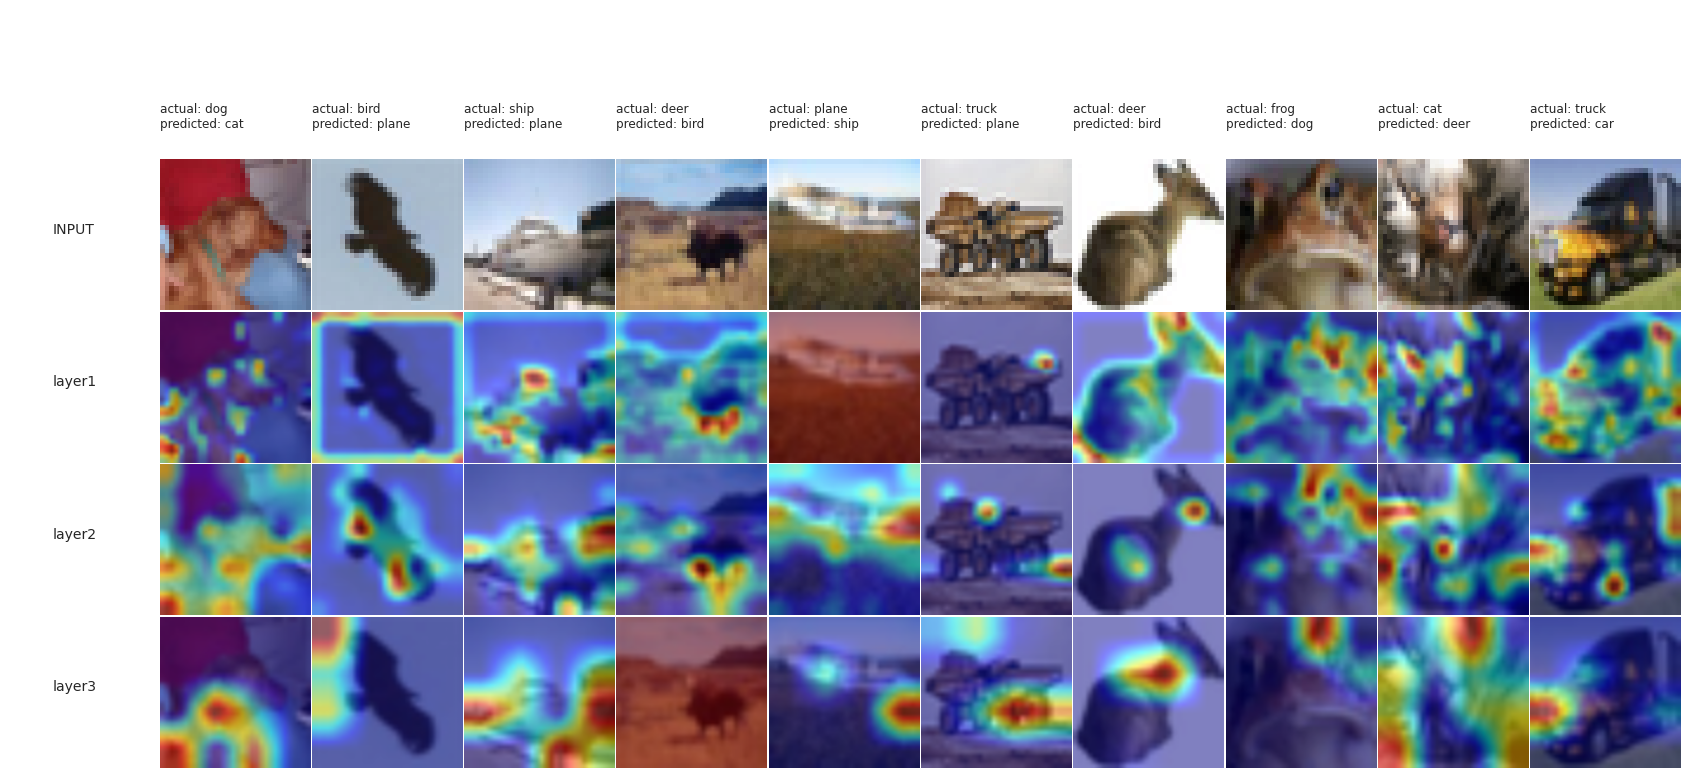

In [28]:
gradcam_output, probs, predicted_classes = generate_gradcam(misclassified_images[10:20], model, target_layers,device)
plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[10:20])